In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


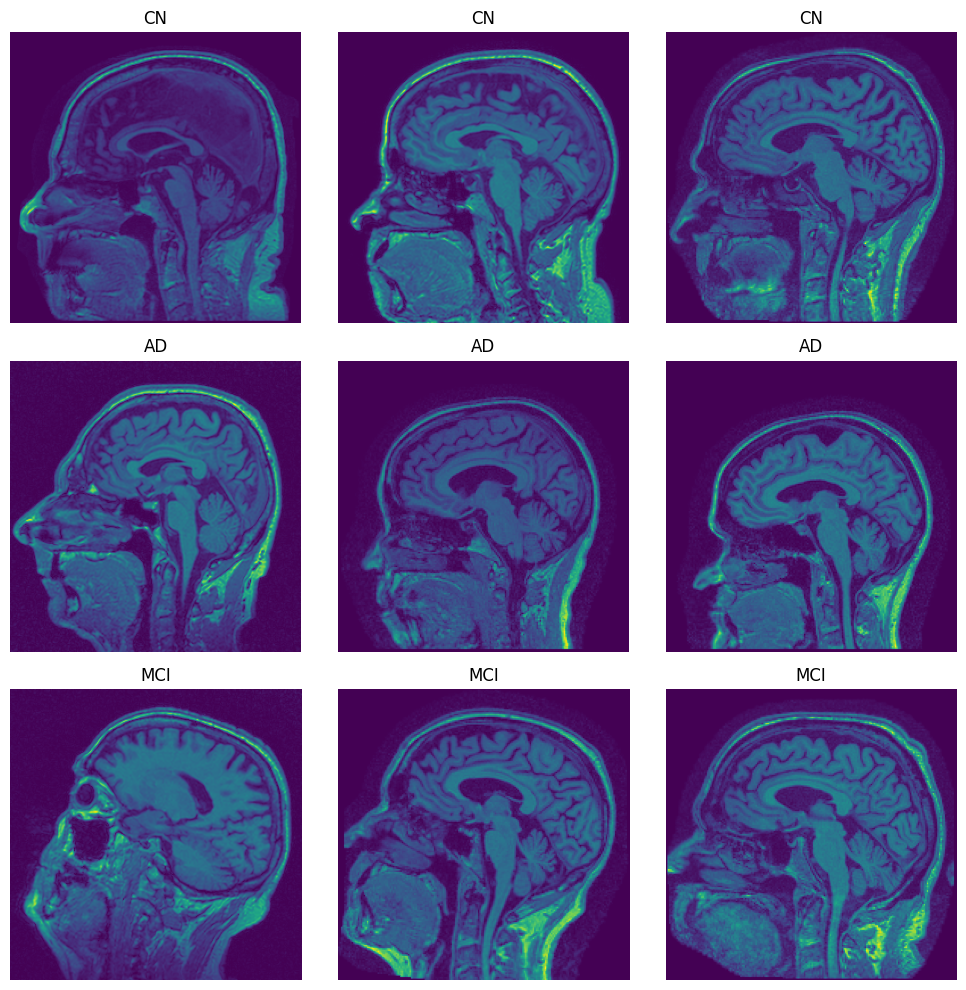

In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
test_folder = '/content/drive/MyDrive/final _dataset/test'
class_names = os.listdir(test_folder)
num_images_per_class = 3

plt.figure(figsize=(10, 10))

for class_name in class_names:
    class_folder = os.path.join(test_folder, class_name)
    image_files = os.listdir(class_folder)[:num_images_per_class]

    for image_file in image_files:
        image_path = os.path.join(class_folder, image_file)
        image = mpimg.imread(image_path)

        plt.subplot(len(class_names), num_images_per_class, class_names.index(class_name) * num_images_per_class + image_files.index(image_file) + 1)
        plt.imshow(image)
        plt.title(class_name)
        plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
main_folder = '/content/drive/MyDrive/final _dataset'

# List of subfolders (train and test)
subfolders = ['train', 'test']

for subfolder in subfolders:
    subfolder_path = os.path.join(main_folder, subfolder)
    class_names = os.listdir(subfolder_path)

    print(f"Number of images in {subfolder} folder:")

    for class_name in class_names:
        class_folder = os.path.join(subfolder_path, class_name)
        num_images = len(os.listdir(class_folder))
        print(f"Class {class_name}: {num_images} images")

    print("-" * 20)

Number of images in train folder:
Class MCI: 797 images
Class AD: 373 images
Class CN: 459 images
--------------------
Number of images in test folder:
Class CN: 119 images
Class AD: 87 images
Class MCI: 197 images
--------------------


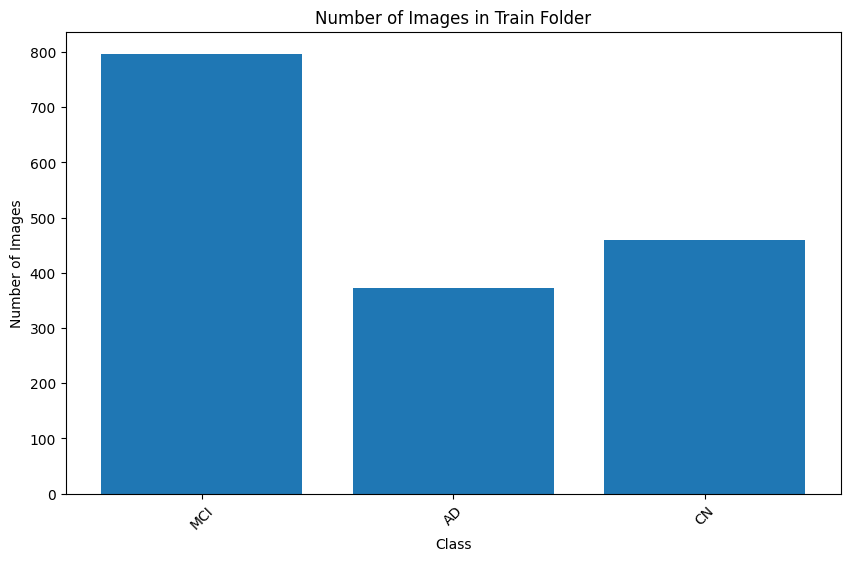

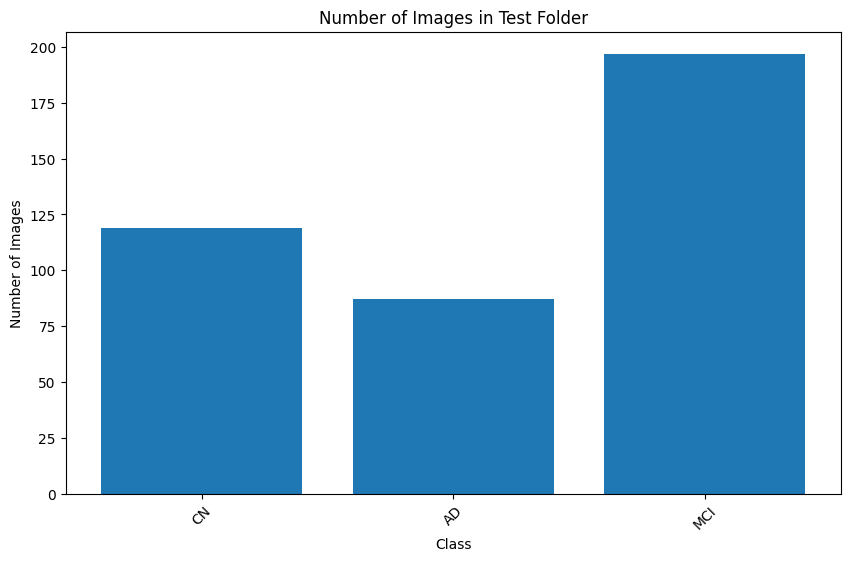

In [ ]:
for subfolder in subfolders:
    subfolder_path = os.path.join(main_folder, subfolder)
    class_names = os.listdir(subfolder_path)
    class_counts = []

    for class_name in class_names:
        class_folder = os.path.join(subfolder_path, class_name)
        num_images = len(os.listdir(class_folder))
        class_counts.append(num_images)

    plt.figure(figsize=(10, 6))
    plt.bar(class_names, class_counts)
    plt.title(f"Number of Images in {subfolder.capitalize()} Folder")
    plt.xlabel("Class")
    plt.ylabel("Number of Images")
    plt.xticks(rotation=45)
    plt.show()

In [ ]:
!pip install pillow

In [ ]:
from PIL import *
Image

<module 'PIL.Image' from '/usr/local/lib/python3.10/dist-packages/PIL/Image.py'>

In [ ]:
import PIL.Image
image_path = '/content/drive/MyDrive/final _dataset/test/AD/AD_106.png'

# Open the image and get its size
image = Image.open(image_path)

image_size = image.size

print(f"Image: {image_path} | Size: {image_size[0]} x {image_size[1]}")

Image: /content/drive/MyDrive/final _dataset/test/AD/AD_106.png | Size: 256 x 256


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
import numpy as np

In [ ]:
# Path to the train dataset folder
train_folder ='/content/drive/MyDrive/final _dataset/train'

# List of class names
class_names = os.listdir(train_folder)

# Image dimensions
image_width, image_height = 128, 128

# Load and preprocess the images
data = []
labels = []

for class_index, class_name in enumerate(class_names):
    class_folder = os.path.join(train_folder, class_name)
    for image_file in os.listdir(class_folder):
        image_path = os.path.join(class_folder, image_file)
        image = Image.open(image_path).convert("L")  # Convert to grayscale
        image = image.resize((image_width, image_height))
        image = np.array(image) / 255.0  # Normalize pixel values
        data.append(image)
        labels.append(class_index)

data = np.array(data)
labels = np.array(labels)

In [ ]:
print(len(class_names))

3


In [ ]:
import tensorflow as tf

In [ ]:
!pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 6.6 MB/s eta 0:00:00


In [ ]:
class SelfAttention(tf.keras.layers.Layer):
    def __init__(self, channels):
        super(SelfAttention, self).__init__()
        self.channels = channels

    def build(self, input_shape):
        self.theta = Conv2D(self.channels // 8, (1, 1), strides=(1, 1), padding='same')
        self.phi = Conv2D(self.channels // 8, (1, 1), strides=(1, 1), padding='same')
        self.g = Conv2D(self.channels // 2, (1, 1), strides=(1, 1), padding='same')
        self.o = Conv2D(self.channels, (1, 1), strides=(1, 1), padding='same')

    def call(self, inputs):
        theta = self.theta(inputs)
        phi = self.phi(inputs)
        g = self.g(inputs)

        theta = tf.reshape(theta, [-1, theta.shape[1] * theta.shape[2], theta.shape[3]])
        phi = tf.reshape(phi, [-1, phi.shape[1] * phi.shape[2], phi.shape[3]])
        g = tf.reshape(g, [-1, g.shape[1] * g.shape[2], g.shape[3]])

        attn = tf.nn.softmax(tf.matmul(theta, phi, transpose_b=True))
        attn_g = tf.matmul(attn, g)

        attn_g = tf.reshape(attn_g, [-1, inputs.shape[1], inputs.shape[2], g.shape[-1]])
        o = self.o(attn_g)

        x = inputs + o
        return x


In [ ]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=42)

# Build the CNN model with SelfAttention
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(image_width, image_height, 1)),
    MaxPooling2D((2, 2)),
    SelfAttention(32),  # Add SelfAttention layer
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')
])


In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# Train the model
batch_size=32
history = model.fit(X_train, y_train, batch_size=batch_size,epochs=50, validation_data=(X_val, y_val))


Epoch 1/50
41/41 [==============================] - 23s 265ms/step - loss: 1.1767 - accuracy: 0.4474 - val_loss: 1.0392 - val_accuracy: 0.5552
Epoch 2/50
41/41 [==============================] - 10s 245ms/step - loss: 1.0590 - accuracy: 0.4712 - val_loss: 0.9741 - val_accuracy: 0.5552
Epoch 3/50
41/41 [==============================] - 10s 253ms/step - loss: 1.0570 - accuracy: 0.4689 - val_loss: 0.9974 - val_accuracy: 0.5613
Epoch 4/50
41/41 [==============================] - 10s 241ms/step - loss: 1.0104 - accuracy: 0.4973 - val_loss: 0.9418 - val_accuracy: 0.5828
Epoch 5/50
41/41 [==============================] - 10s 245ms/step - loss: 0.9388 - accuracy: 0.5441 - val_loss: 0.8694 - val_accuracy: 0.6288
Epoch 6/50
41/41 [==============================] - 10s 246ms/step - loss: 0.7927 - accuracy: 0.6608 - val_loss: 0.8045 - val_accuracy: 0.6564
Epoch 7/50
41/41 [==============================] - 10s 233ms/step - loss: 0.6349 - accuracy: 0.7444 - val_loss: 0.6640 - val_accuracy: 0.7025

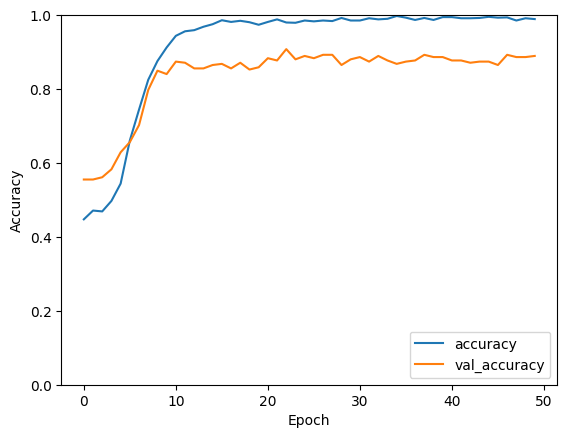

In [ ]:
# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 self_attention (SelfAttent  (None, 63, 63, 32)        1336      
 ion)                                                            
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                        

In [ ]:
# Path to the test dataset folder
test_folder = '/content/drive/MyDrive/final _dataset/train'

# Load and preprocess the test images
test_data = []
test_labels = []

for class_index, class_name in enumerate(class_names):
    class_folder = os.path.join(test_folder, class_name)
    for image_file in os.listdir(class_folder):
        image_path = os.path.join(class_folder, image_file)
        image = Image.open(image_path).convert("L")  # Convert to grayscale
        image = image.resize((image_width, image_height))
        image = np.array(image) / 255.0  # Normalize pixel values
        test_data.append(image)
        test_labels.append(class_index)

test_data = np.array(test_data)
test_labels = np.array(test_labels)
bs=3
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_data, test_labels,batch_size=bs, verbose=2)

print(f"Test accuracy: {test_accuracy:.4f}")


543/543 - 5s - loss: 0.1554 - accuracy: 0.9779 - 5s/epoch - 10ms/step
Test accuracy: 0.9779


In [ ]:
print(f"Test accuracy percentage: {test_accuracy*100}")

Test accuracy percentage: 97.79005646705627


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns



1/1 [==============================] - 0s 17ms/step


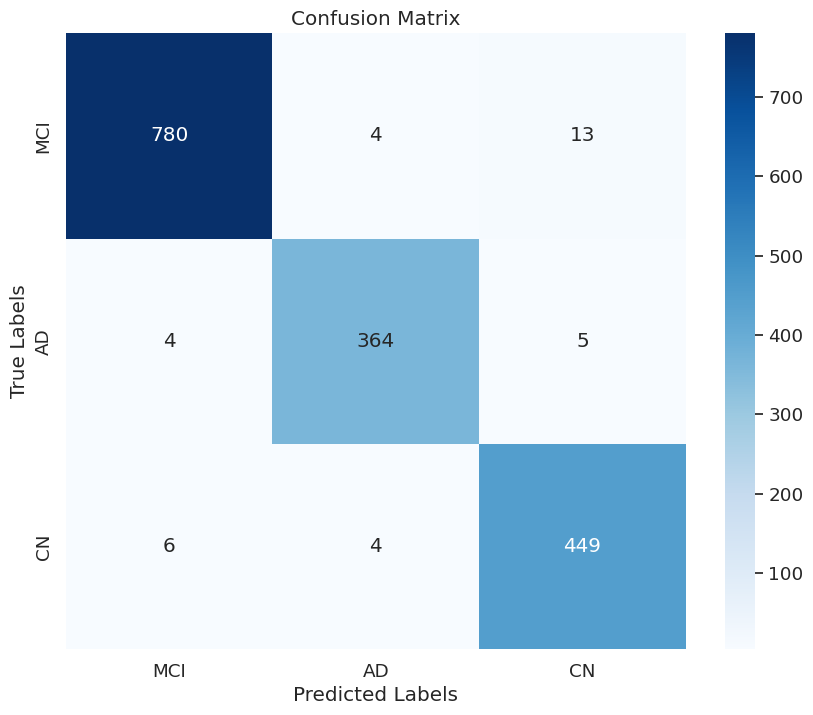

In [ ]:
from sklearn.metrics import confusion_matrix

batch_size = 3
num_batches = len(test_data) // batch_size

all_true_labels = []
all_predicted_labels = []

for i in range(num_batches):
    start_idx = i * batch_size
    end_idx = (i + 1) * batch_size
    batch_data = test_data[start_idx:end_idx]
    batch_labels = test_labels[start_idx:end_idx]

    batch_predictions = model.predict(batch_data)
    batch_predicted_labels = np.argmax(batch_predictions, axis=1)

    all_true_labels.extend(batch_labels)
    all_predicted_labels.extend(batch_predicted_labels)

confusion_mat = confusion_matrix(all_true_labels, all_predicted_labels)
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)  # Adjust font size
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
print(confusion_mat)

[[780   4  13]
 [  4 364   5]
 [  6   4 449]]


In [ ]:
from sklearn.metrics import confusion_matrix,precision_score,recall_score,f1_score
average_setting = 'weighted'
precision = precision_score(all_true_labels, all_predicted_labels, average=average_setting)
recall = recall_score(all_true_labels, all_predicted_labels, average=average_setting)
f1 = f1_score(all_true_labels, all_predicted_labels, average=average_setting)

print(f'Precision ({average_setting}): {precision:.2f}')
print(f'Recall ({average_setting}): {recall:.2f}')
print(f'F1 Score ({average_setting}): {f1:.2f}')


Precision (weighted): 0.98
Recall (weighted): 0.98
F1 Score (weighted): 0.98
